In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [2]:
def read_image(fname):
    return cv2.cvtColor(
        cv2.imread(fname),
        cv2.COLOR_BGR2RGB
    )

In [3]:
def load_test_images():
    images = []
    for name in ['test1.jpg', 'test2.jpg', 'test3.jpg']:
        images.append(read_image('test_images/' + name))
    return images

In [4]:
TEST_IMAGES = load_test_images()

In [36]:
def print_images(images, title = None):
    f, axs = plt.subplots(1, 3, figsize=(20,20))
    if title:
        print(title)
        print('-' * len(title))
    for i, image in enumerate(images):
        axs[i].imshow(image)
    plt.show()

Test Images
-----------


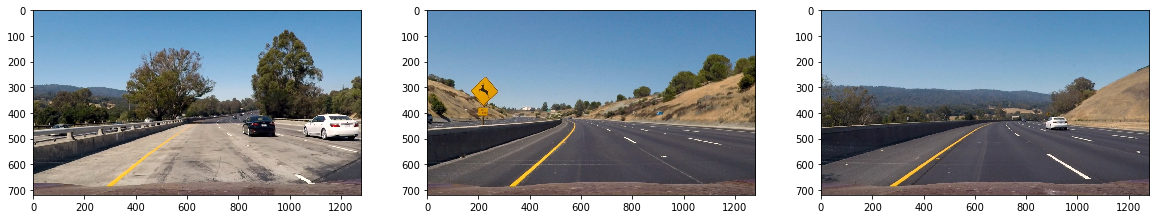

In [37]:
print_images(TEST_IMAGES, 'Test Images')

In [38]:
def get_image_size(image):
    return image.shape

In [39]:
(H, W, D) = get_image_size(TEST_IMAGES[0])

In [40]:
print('Image Dimensions: ' + str(W) + ' x ' + str(H))

Image Dimensions: 1280 x 720


In [41]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [42]:
def print_random_boxes(images):
    random_boxes = [
        ((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
        ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

    drawn_images = [draw_boxes(image, random_boxes) for image in images]

    print_images(drawn_images, "Test Draw Boxes")

Test Draw Boxes
---------------


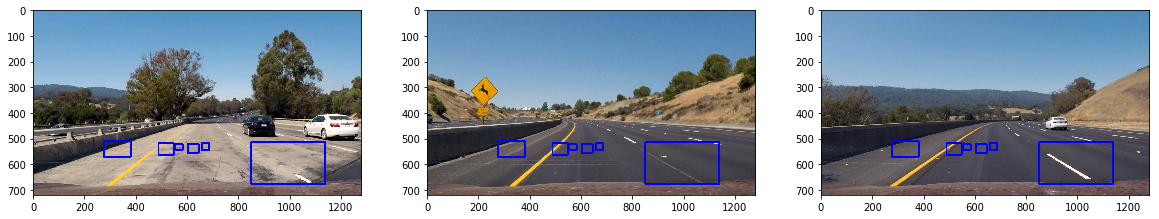

In [43]:
print_random_boxes(TEST_IMAGES)

In [44]:
def load_train_images():
    cars = []
    non_cars = []
    for image in glob.glob('train_images/vehicles/*/*'):
        cars.append(read_image(image))
    for image in glob.glob('train_images/non-vehicles/*/*'):
        non_cars.append(read_image(image))
    return cars, non_cars

In [45]:
CARS, NON_CARS = load_train_images()

Cars
----


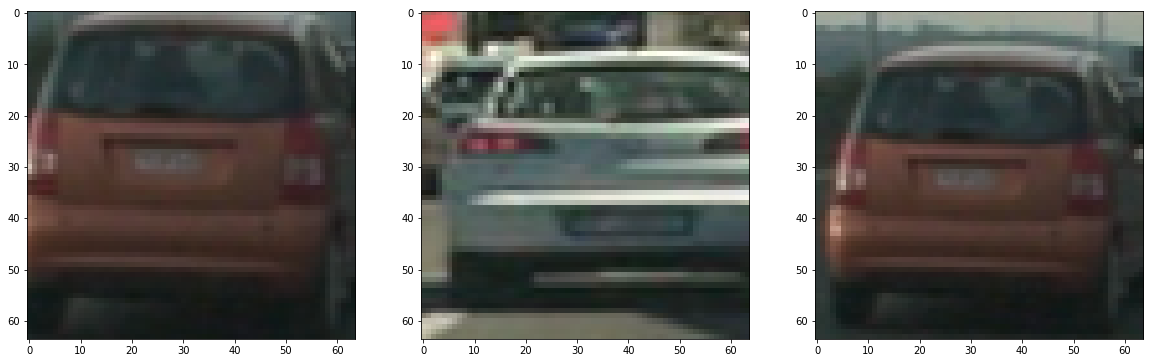

Non Cars
--------


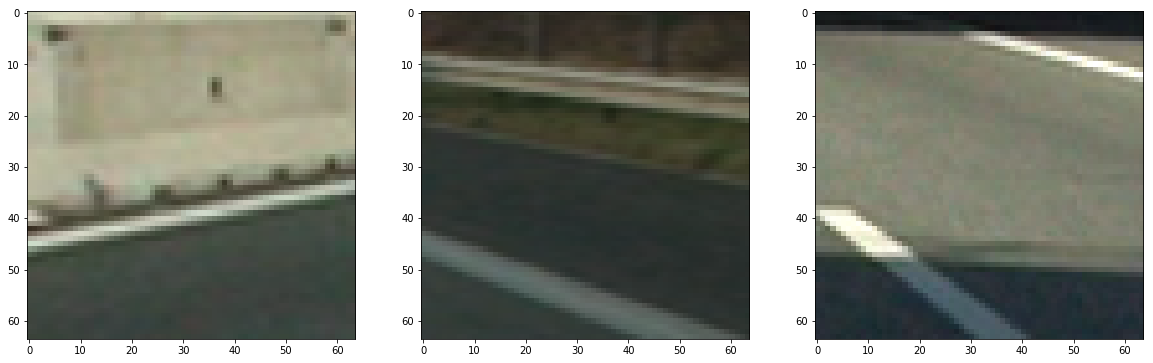

In [46]:
print_images(CARS[0:3], 'Cars')
print_images(NON_CARS[0:3], 'Non Cars')

In [122]:
def get_color_histogram(image, nbins=32, bins_range=(0, 256), vis=True):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    if vis:
        # Generating bin centers
        bin_edges = rhist[1]

        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

        # Return the individual histograms, bin_centers and feature vector
        return rhist, ghist, bhist, bin_centers, hist_features
    
    return hist_features

In [123]:
def print_color_histogram(image, title = None):
    plt.subplots(1, 3, figsize=(20,4))
    
    rh, gh, bh, bincen, feature_vec = get_color_histogram(image, nbins=32, bins_range=(0, 256))

    if title:
        print(title)
        print('-' * len(title))

    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')

Car Color Histogram
-------------------


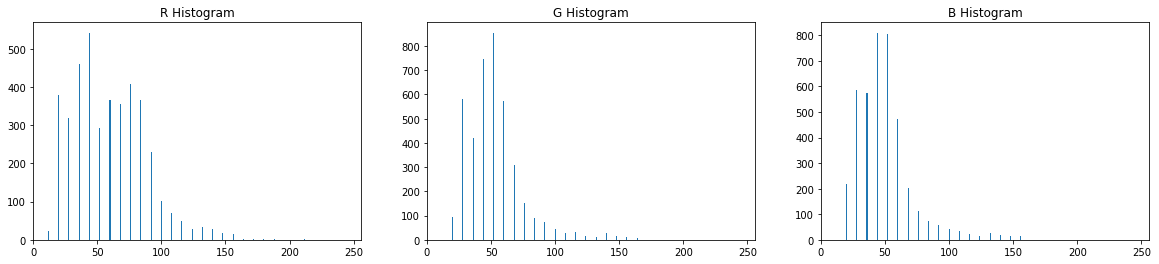

In [124]:
print_color_histogram(CARS[0], 'Car Color Histogram')

Non Car Color Histogram
-----------------------


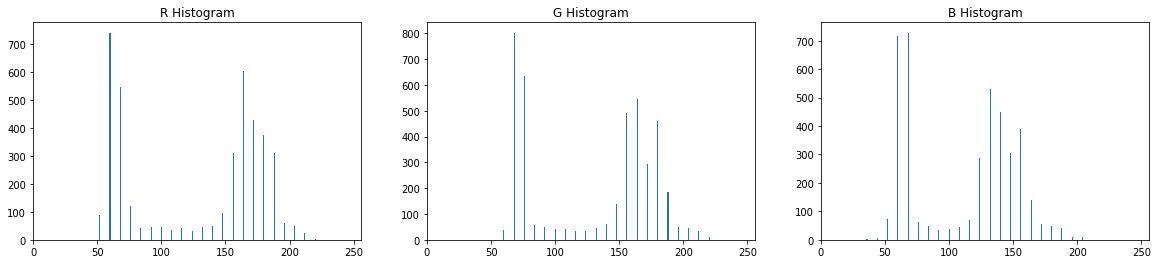

In [50]:
print_color_histogram(NON_CARS[0], 'Non Car Color Histogram')

In [59]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [75]:
def print_color_spaces(img, title = None):
    f, axs = plt.subplots(2, 3, figsize=(20, 10))
    color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
    
    if title:
        print(title)
        print('-' * len(title))

    for i, color_space in enumerate(color_spaces):
        ax = axs[int(i / 3)][i % 3]
        ax.plot(bin_spatial(img, color_space))
        ax.set_title(color_space, fontsize=20)
    f.tight_layout() 

Car Color Spaces
----------------


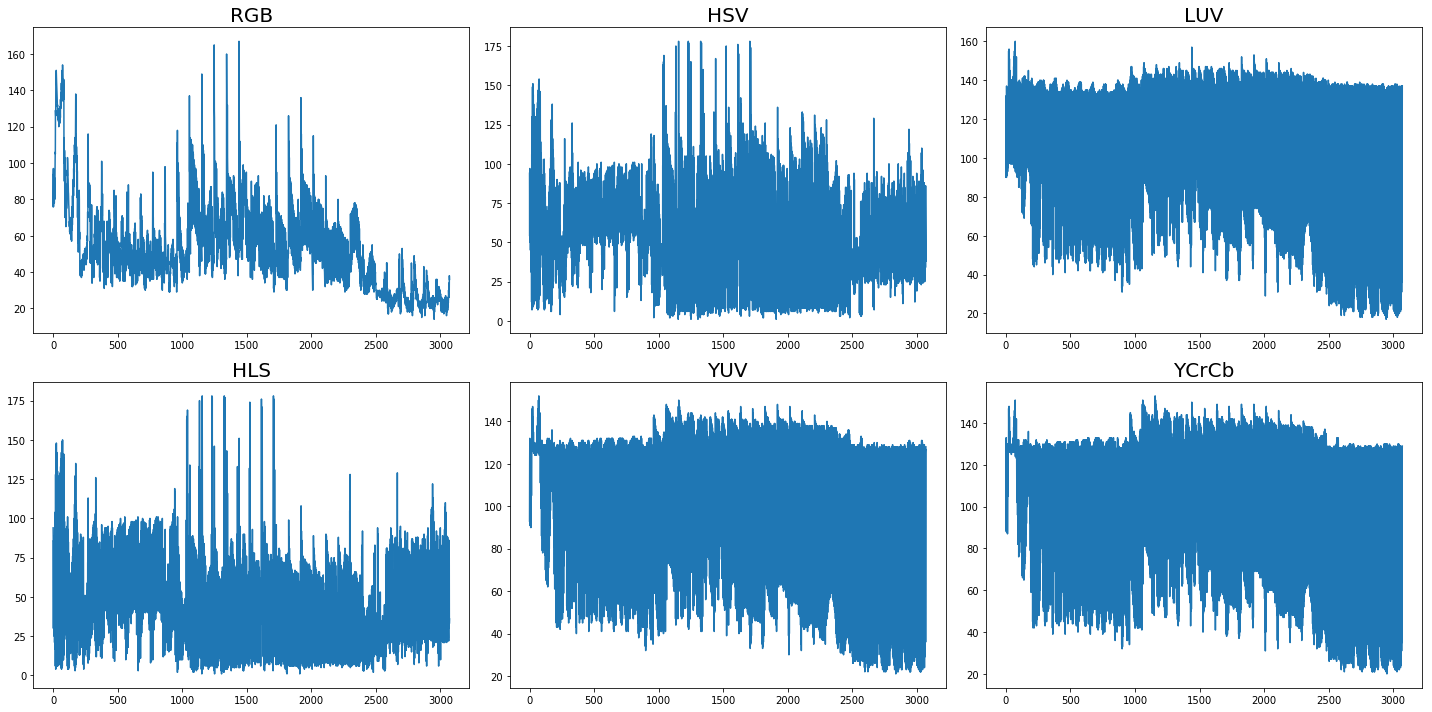

In [76]:
print_color_spaces(CARS[0], 'Car Color Spaces')

Non Car Color Spaces
--------------------


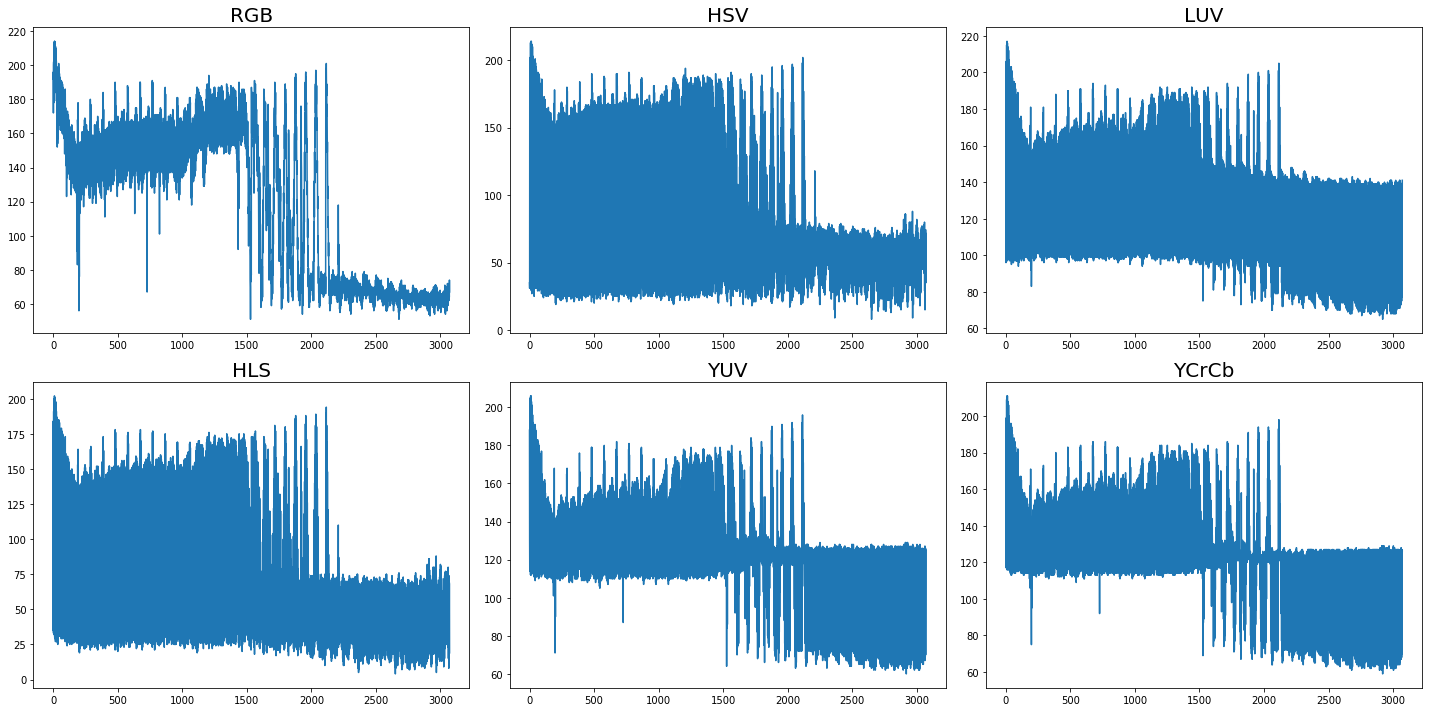

In [77]:
print_color_spaces(NON_CARS[0], 'Non Car Color Spaces')

In [84]:
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(image, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if vis == True:
        features, hog_image = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
            visualise=True, feature_vector=False, block_norm="L2-Hys")
        return features, hog_image
    else:      
        features = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
           cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
           visualise=False, feature_vector=feature_vec, block_norm="L2-Hys")
    return features

In [87]:
def print_hog_features(image):
    features, hog_image = get_hog_features(image, vis=True)
    
    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')

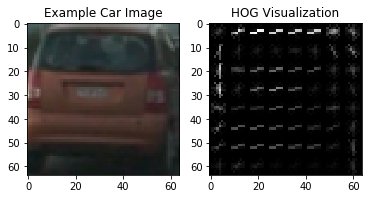

In [88]:
print_hog_features(CARS[0])

In [160]:
from sklearn.preprocessing import StandardScaler

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # Read in each one by one
        # image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = get_color_histogram(feature_image, nbins=hist_bins, bins_range=hist_range, vis=False)
        # Append the new feature vector to the features list
        # print(spatial_features, hist_features)
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

In [163]:
CAR_FEATURES     = extract_features(CARS)
NON_CAR_FEATURES = extract_features(NON_CARS)

In [164]:
def print_extracted_features(car_images, car_features, non_car_images, notcar_features):
    if len(car_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)

        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        car_ind = np.random.randint(0, len(car_images))
        # Plot an example of raw and scaled features
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(car_images[car_ind])
        plt.title('Original Image')
        plt.subplot(132)
        # print(X[0][car_ind])
        plt.plot(X[car_ind])
        plt.title('Raw Features')
        plt.subplot(133)
        plt.plot(scaled_X[car_ind])
        plt.title('Normalized Features')
        fig.tight_layout()

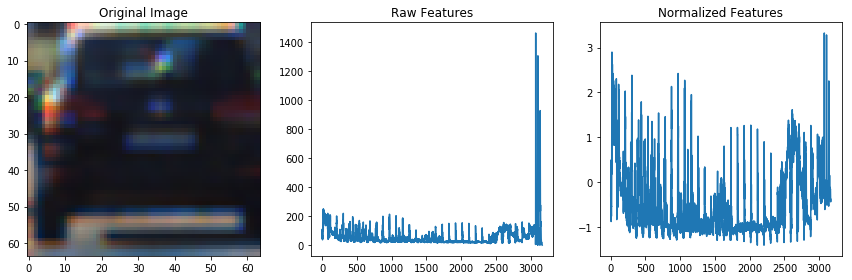

In [166]:
print_extracted_features(CARS, CAR_FEATURES, NON_CARS, NON_CAR_FEATURES)